In [357]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [358]:
trans = transforms.Compose([transforms.ToTensor()])

In [359]:
root = '/home/tete/dataset/'
if not os.path.exists(root):
    os.mkdir(root)

In [153]:
train_set=dset.STL10(root=root, transform = trans, split='train',download=False)
test_set =dset.STL10(root=root, transform = trans, split='test',download=False)

In [360]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,shuffle=False)

In [361]:
train_set.data[0].shape

(3, 96, 96)

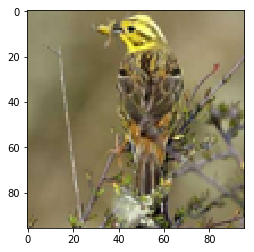

In [362]:
plt.imshow(train_set.data[0].transpose(1,2,0))

In [363]:
def imshow(inp,title="Image"):
    inp = inp.transpose((1, 2, 0))
    #You can just delete these line to get a better image
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = np.clip(std * inp + mean, 0,1)
    #################################################
    s=inp.shape
    lw = s[0]/s[1]
    figsize = [batch_size, round(lw*batch_size)]
    plt.figure(figsize=(50,50))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
plt.pause(0.001) # pause a bit so that plots are updated

In [364]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 96, 96])

In [365]:
grid_img = torchvision.utils.make_grid(next(iter(train_loader))[0], nrow=batch_size//2)

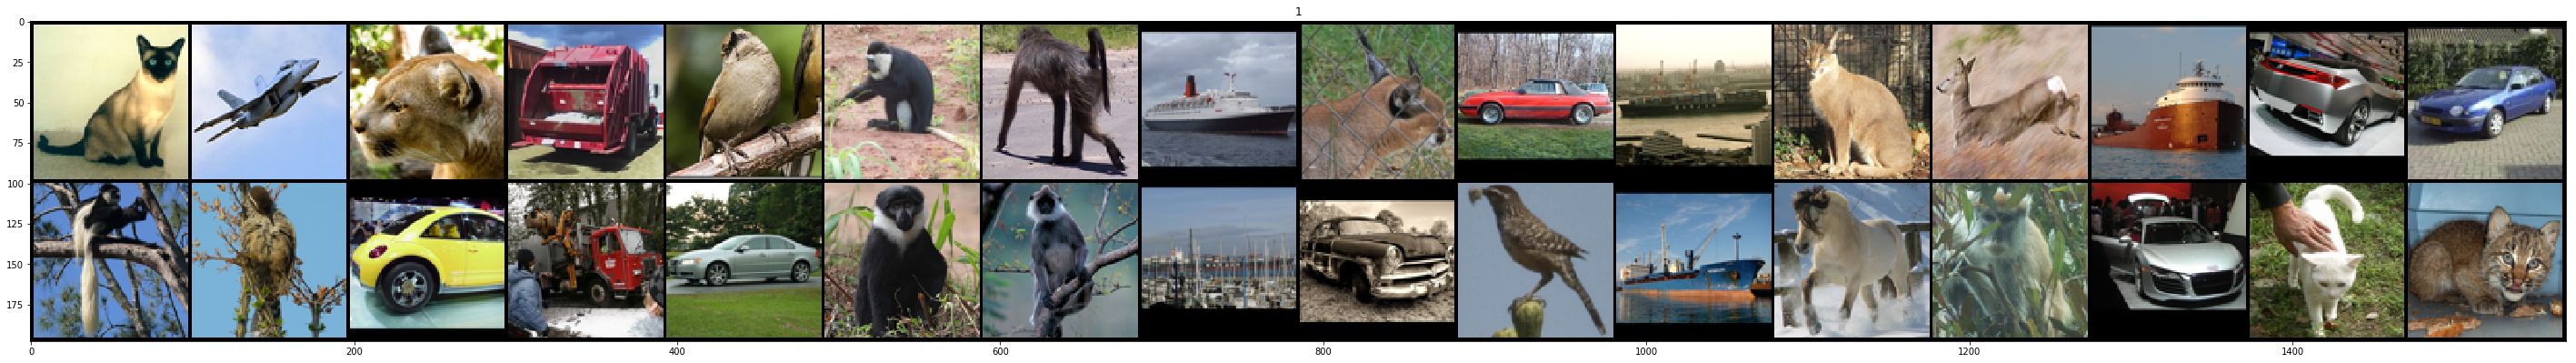

In [366]:
imshow(grid_img.numpy(),"1")

In [434]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),  # b, 32, 96,96
            nn.ReLU(True),
            nn.MaxPool2d(2),  # rgb, 32, 48, 48
            nn.Conv2d(32, 64, 3, stride=1, padding=1),  # b, 64, 48, 48
            nn.ReLU(True),
            nn.MaxPool2d(2),  # b, 64, 24,24
            nn.Conv2d(64, 8, 3, stride=1, padding=1),  # b, 8, 24, 24
            nn.ReLU(True),
            nn.MaxPool2d(2)  # b, 8, 12,12
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 64, 3, stride=2),  # b, 64, 25, 25
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 5, stride=2, padding=2),  # b, 8, 49, 49
            nn.ReLU(True),
            nn.ConvTranspose2d(64,  64,  3, stride=2,padding =2,output_padding=1),  # b, 3, 96, 96
            nn.Conv2d(64,  3,  3,           stride=1  ,padding =1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [435]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-9)

In [440]:
num_epochs =50
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to('cuda') if torch.cuda.is_available() else img
        output =model(img)
        loss =criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10==0):
        print("Epoch loss : {} at epoch : {}".format(loss,epoch))

Epoch loss : 0.008773609064519405 at epoch : 0
Epoch loss : 0.005165024660527706 at epoch : 10
Epoch loss : 0.007335509639233351 at epoch : 20
Epoch loss : 0.005574787501245737 at epoch : 30
Epoch loss : 0.005647885613143444 at epoch : 40


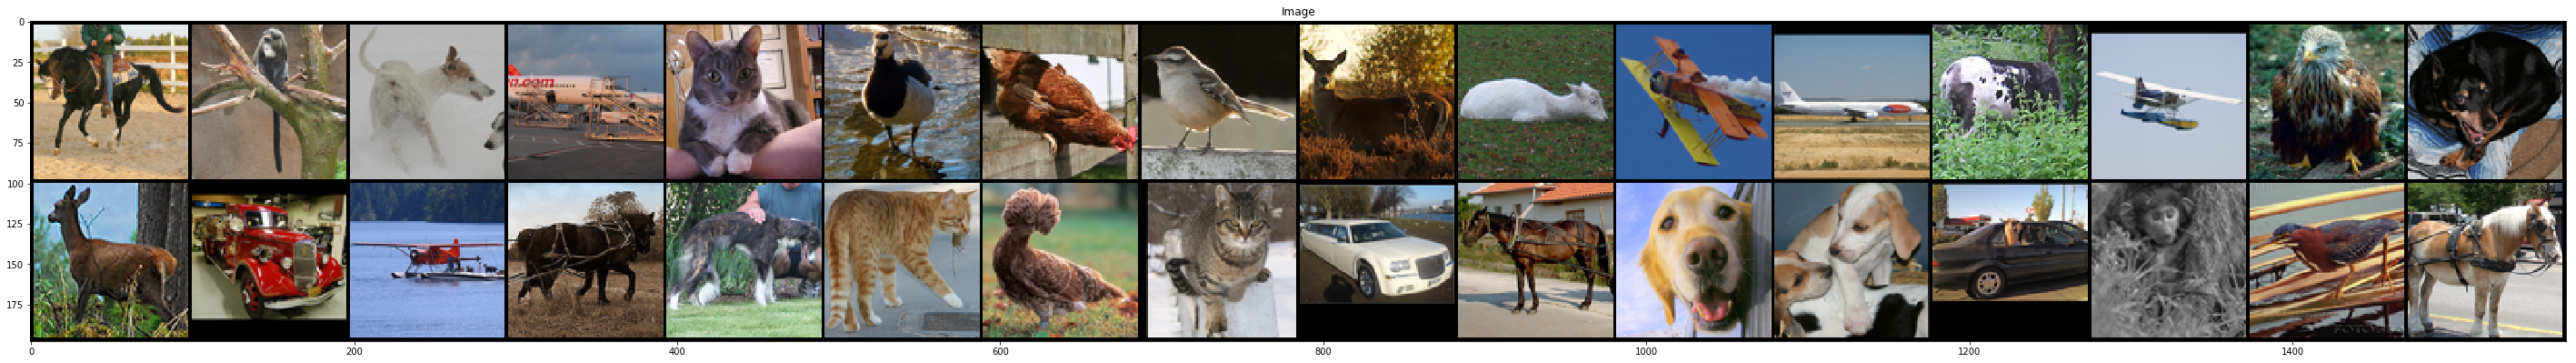

In [441]:
test = next(iter(test_loader))[0]
test_img = torchvision.utils.make_grid(test, nrow=batch_size//2).numpy()
imshow(test_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


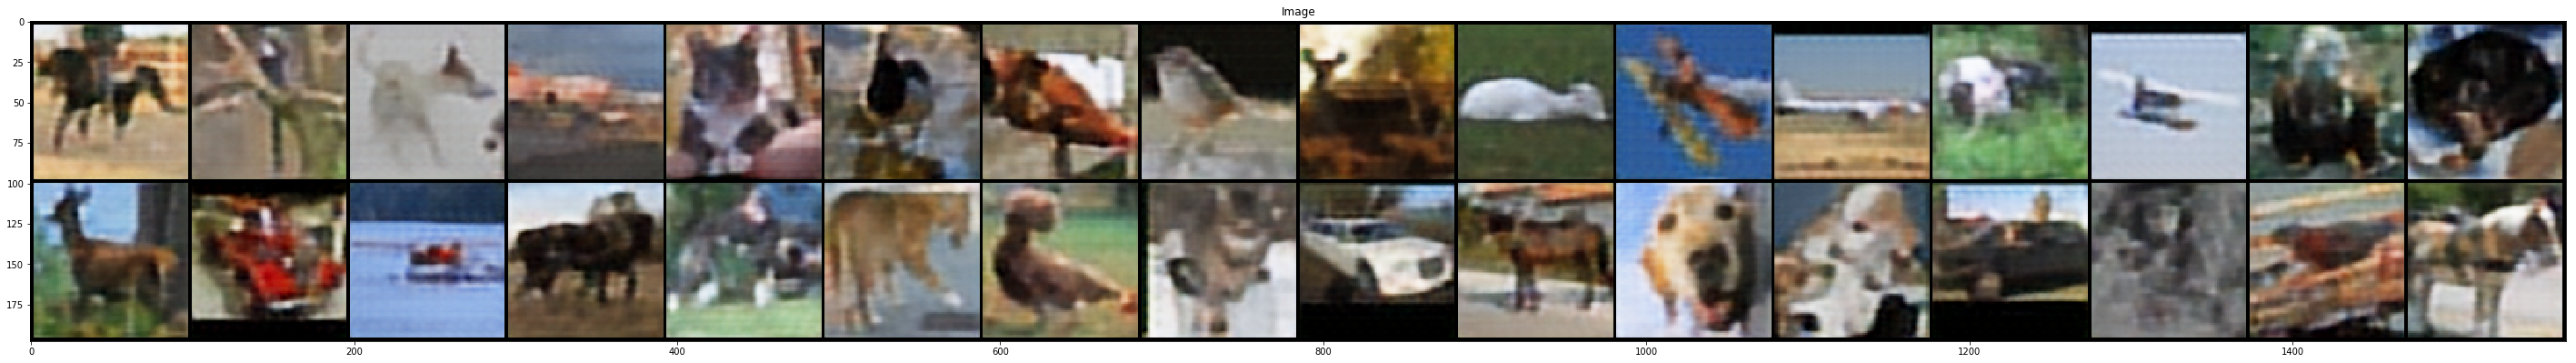

In [442]:
with torch.no_grad():
    output_model = model(test.to('cuda'))
predict_img=torchvision.utils.make_grid(output_model, nrow=batch_size//2).cpu().numpy()
imshow(predict_img)